#### Imports and plot format

In [1]:
# execute if not installed
import sys
import os
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
os.makedirs('output', exist_ok=True)

In [3]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

# Mauna Loa

Experiment of CO2 measurements in Mauna Loa using single output Gaussian process with Spectral Mixture Kernel.

In [4]:
# dataset mauna loa
from sklearn.datasets import fetch_openml

# function to load dataset
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

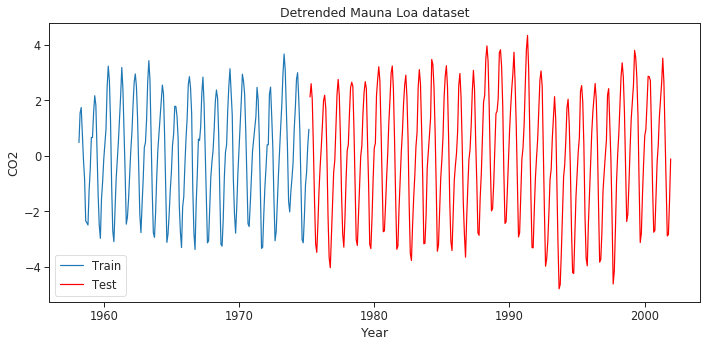

In [5]:
x, y_old = load_mauna_loa_atmospheric_co2()

# detrend 
poly = np.polyfit(x, y_old, 3)
y = y_old - np.polyval(poly, x)

trend = y_old - y
stop = 200

# plot
plt.plot(x[:stop], y[:stop], label='Train')
plt.plot(x[stop:], y[stop:], 'r', label='Test')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2');
plt.title('Detrended Mauna Loa dataset')
plt.tight_layout();

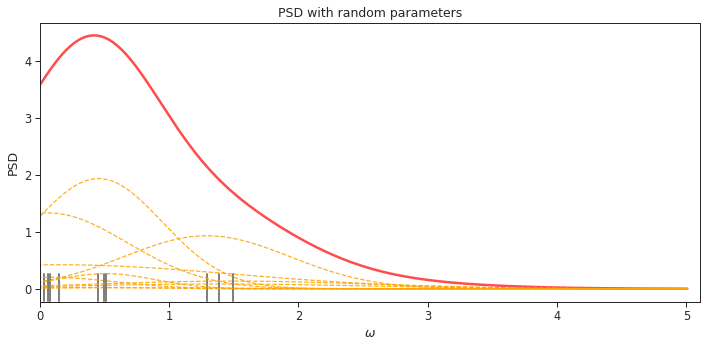

In [6]:
# add data
data = mogptk.Data()
data.add(x[:stop], y[:stop])

# create model
model = mogptk.SM(data, Q=10)

mogptk.plot_psd(model)
plt.title('PSD with random parameters')
plt.tight_layout();

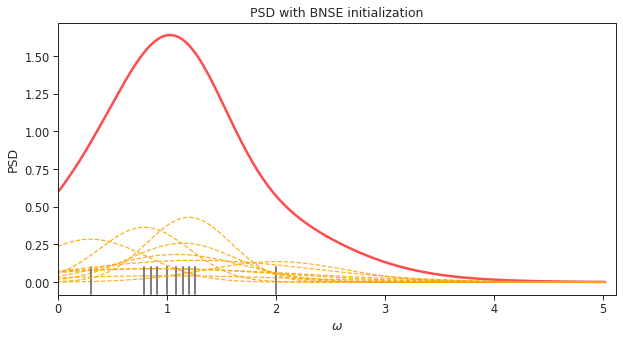

In [7]:
method = 'BNSE'
model.init_params(method)

mogptk.plot_psd(model, title='PSD with {} initialization'.format(method))

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 54.746826
  Number of iterations: 339
  Number of functions evaluations: 435
CPU times: user 2.69 s, sys: 512 ms, total: 3.2 s
Wall time: 2.82 s


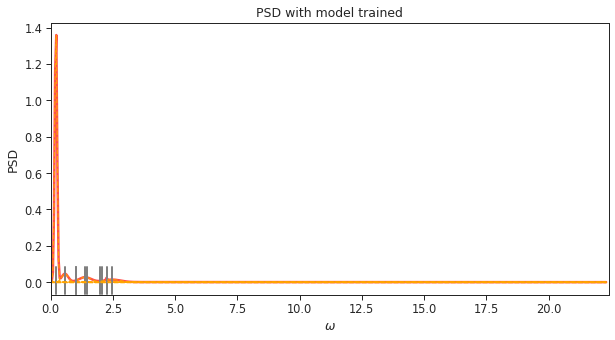

In [8]:
%%time 
model.train(method='BFGS', maxiter=1000, disp=False, learning_rate=0.001)

mogptk.plot_psd(model, title='PSD with model trained')

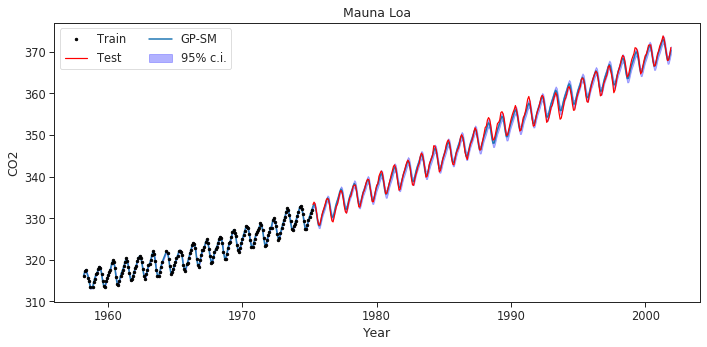

In [9]:
# prediction
x_pred = {0:x[:, np.newaxis]}
x_pred, y_pred, y_var = model.predict(x_pred)

# plot
plt.plot(x[:stop], trend[:stop] + y[:stop], '.k', label='Train')
plt.plot(x[stop:], trend[stop:] + y[stop:], '-r', label='Test')
plt.plot(x_pred[0], trend + y_pred[0], lw=1.5, zorder=1, label='GP-SM')
plt.fill_between(x_pred[0].reshape(-1),
                 trend + y_pred[0] + 2 * np.sqrt(y_var[0]),
                 trend + y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                 alpha=0.3,
                 zorder=1,
                 label='95% c.i.')
plt.legend(ncol=2)
plt.title('Mauna Loa')
plt.xlabel('Year')
plt.ylabel('CO2')
plt.xlim(x[0], x[-1])
plt.tight_layout();

# Air Quality MOGP

Experiment on multioutput ussing the mogptk toolbox.

2. __CO(GT)__ True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3. __PT08.S1(CO)__ PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4. __NMHC(GT)__ True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5. __C6H6(GT)__ True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6. __PT08.S2(NMHC)__ PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7. __NOx(GT)__ True hourly averaged NOx concentration in ppb (reference analyzer)
8. __PT08.S4(NO2)__ PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9. __NO2(GT)__ True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10. __PT08.S4(NO2)__ PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11. __PT08.S5(O3)__ PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12. __T__ Temperature in Â°C
13. __RH__ Relative Humidity (%)
14. __AH__ AH Absolute Humidity 

__Load and Pre-processing__

In [10]:
# load
df = pd.read_csv('data/AirQualityUCI.csv', delimiter=';')

# last 2 columns are only nans
df = df.iloc[:, :-2]

# drop the rows with nan values
df.dropna(inplace=True)

# First 2 columns are date and time, we convert it to a single column with datetime format
dates = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# create column with datetime values
df['timedate'] = dates

# define a initial date to compare all other to
ini_date = pd.Timestamp('2004-03-10 00:00:00.0')

# get elapsed hours
df['time'] = (dates - ini_date) / pd.Timedelta(hours=1)

# drop useless columns
df.drop(columns=['Time', 'Date'], inplace=True)

In [11]:
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,timedate,time
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,18.0
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,19.0
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,20.0
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,21.0
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,22.0


We check the number of missing values per column, registered as -200 (minimun value of the sensor)

In [12]:
(df == -200).sum(0)

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
timedate            0
time                0
dtype: int64

### mogptk data structure

MOGP toolbox uses the following structure:
Given $m$ channels, each one with its inputs $x_i$ and output $y_i$, $i=1,\ldots,m$. The toolbox uses to train

* dict of inputs $x$.
* dict of outputs $y$.

## Data to use

* As outputs we will use the ground thruth of: CO, NMHC, C6H6, NOx, NO2
* I a first experiment will only use time as input.

For this we will use the mogptk.Data class, which allows to use the different models in the toolbox.

In [13]:
# we use the first 200 rows, the first 3 days
n_experiment = 200
ini_t = 300
df2 = df.iloc[ini_t:n_experiment + ini_t]

In [14]:
# columns to use
cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# class for storing data
data = mogptk.Data()

for i, c in enumerate(cols):
    # index of non-missing values
    idx = (df2[c] != -200)
    
    print('Channel {} with {} non-missing values'.format(c, idx.sum()))
    
    # add data to the model
    x = df2['time'][idx].values
    y = df2[c][idx].values
    
    data.add(x, y)

print('Points per channel:', data.get_channel_sizes())

Channel CO(GT) with 196 non-missing values
Channel NMHC(GT) with 200 non-missing values
Channel C6H6(GT) with 200 non-missing values
Channel NOx(GT) with 192 non-missing values
Channel NO2(GT) with 192 non-missing values
Points per channel: [196, 200, 200, 192, 192]


__Remove random portions of the data to simulate sensor failure__

In [15]:
# randomly sample from the data
for i in range(5):
    data.remove_randomly(channel=i, pct=0.7)

# drop chunks to simulate sensor failure
data.remove_range(0, 425, 460)
data.remove_range(1, 480, None)
data.remove_range(2, 480, None)
data.remove_range(3, 480, None)
data.remove_range(4, None, 350)

create a function for plotting the experiment

In [16]:
def plot_air_experiment(x_train=None,
                        y_train=None,
                        x_all=None,
                        y_all=None,
                        x_pred=None,
                        y_pred=None,
                        var_pred=None,
                        ylims=None,
                        cols=cols,
                        title=''):
    """
    5x1 Plot for the Air quality experiment
    """
    if ylims is None:
        ylims = [(-1, 7), (-60, 900), (-5, 32), (-50, 380), (10, 170)]
        
    f, axarray = plt.subplots(5, 1, sharex=True, figsize=(12, 10))

    for i in range(5):
        # plot post mean
        if (x_pred is not None) & (y_pred is not None):
            axarray[i].plot(x_pred[i] ,y_pred[i], label='Post.Mean', c=sns.color_palette()[i])
            
        # error bars
        if (x_pred is not None) & (y_pred is not None) & (var_pred is not None):
            axarray[i].fill_between(x_pred[i].reshape(-1),
                                    y_pred[i] + 2 * np.sqrt(var_pred[i]),
                                    y_pred[i] - 2 * np.sqrt(var_pred[i]),
                                    alpha=0.3,
                                    label='95% c.i.',
                                    color=sns.color_palette()[i]
                                   )
        # plot trainning points
        if (x_train is not None) & (y_train is not None):
            axarray[i].plot(x_train[i], y_train[i], '.k', ms=6, label='Training points')
            
        # plot ground truth will all data
        if (x_all is not None) & (y_all is not None):
            axarray[i].plot(x_all[i], y_all[i], '--k', label='All data', alpha=0.7)

        axarray[i].set_ylabel(cols[i][:-4])
        axarray[i].set_ylim(ylims[i])

    plt.legend(fontsize=12, ncol=4, bbox_to_anchor=(0.35, 5.65, 0.5, 0.5))
    plt.xlabel('Hours')
    plt.xlim(df2['time'].values[0] - 1, df2['time'].values[-1] + 1)
    plt.suptitle(title, y=0.95)

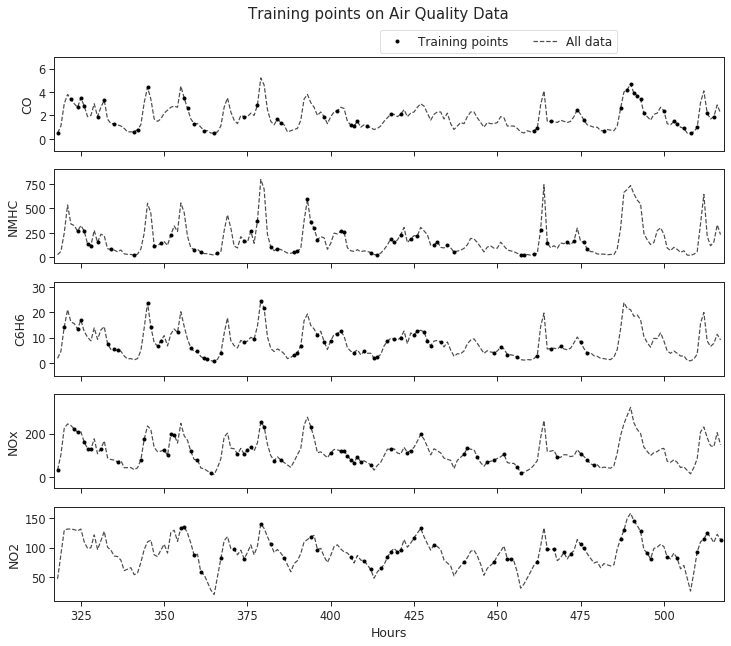

In [17]:
title='Training points on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    title=title
                   )

# 1. Independant GP with SM kernel (IGP)

In [18]:
# Spectral Mixture kernel
Q = 4 # number of mixtures
D = 1 # input dim

# prediction inputs
x_pred = np.linspace(df2['time'].values[0], df2['time'].values[-1], 500)
x_pred = {0:x_pred[:, np.newaxis]}

mean_list = []
var_list = []

# metric containers
igp_mae = np.zeros(5)
igp_mape = np.zeros(5)
igp_mse = np.zeros(5)

for i in range(5):
    
    data_single = mogptk.Data()
    data_single.add(data.X[i], data.Y[i])
    
    # first get the sm kernel params set
    model = mogptk.SM(data_single, Q=3)
    model.init_params('BNSE')
    model.train(method='L-BFGS-B', maxiter=3000, disp=False)
    
    # predict
    x, mean, var = model.predict(x_pred)
    
    mean_list.append(mean[0].reshape(-1))
    var_list.append(var[0].reshape(-1))
    
    # ERROR METRICS
    # predict on all data input 
    
    # generate inputs in the same points as the training set
    idx = df2[cols[i]] != -200
    X_pred = {0:(df2['time'][idx].values)[:, np.newaxis]}
    
    x, mean, var = model.predict(X_pred)
    
    diff = mean[0] - df2[cols[i]][idx].values
    
    igp_mae[i] = np.abs(diff).mean()
    igp_mape[i] = (np.abs(diff) / df2[cols[i]][idx].values).mean()
    igp_mse[i] = (diff**2).mean()

pd.DataFrame(np.c_[igp_mae, igp_mape, igp_mse], columns=['MAE', 'MAPE', 'MSE'])

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 63.533271
  Number of iterations: 532
  Number of functions evaluations: 995
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 514.944847
  Number of iterations: 12
  Number of functions evaluations: 63
INFO:tensorflow:Optimization terminated with:
  Message: Maximum number of iterations has been exceeded.
  Objective function value: 150.223827
  Number of iterations: 3000
  Number of functions evaluations: 7485
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 319.521627
  Number of iterations: 10
  Number of functions evaluations: 67
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 202.914024
  Number of iterations: 1196
  

,MAE,MAPE,MSE
0,0.451676,0.286096,0.453022
1,104.021325,1.112350,24380.622759
2,4.237021,0.740035,40.192106
3,94.479848,0.800844,13463.593000
4,16.011191,0.217011,455.437790


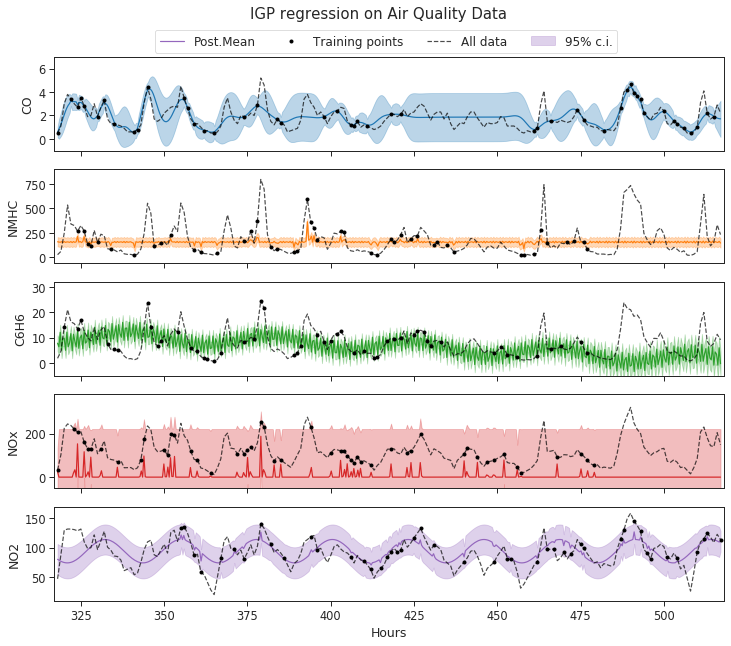

In [19]:
title = 'IGP regression on Air Quality Data'

# duplicate x_pred to satisfy function format
x_pred = np.linspace(df2['time'].values[0], df2['time'].values[-1], 500)
x_pred = [x_pred for i in range(5)]

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=mean_list,
                    var_pred=var_list,
                    title=title
                   )
# plt.savefig('output/air_quality_igp.pdf', bbox_inches='tight')

# 2. Multioutput Spectral Mixture (MOSM)

In [20]:
model_mosm = mogptk.MOSM(data, Q=4)
model_mosm.init_params('means')

__Optimice__

In [21]:
%%time
model_mosm.train(method='L-BFGS-B', maxiter=3000, learning_rate=0.001)

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 859.160098
  Number of iterations: 3000
  Number of functions evaluations: 3211
Done
CPU times: user 7min 29s, sys: 29.2 s, total: 7min 59s
Wall time: 6min 14s


__Predict on all hours and plot__

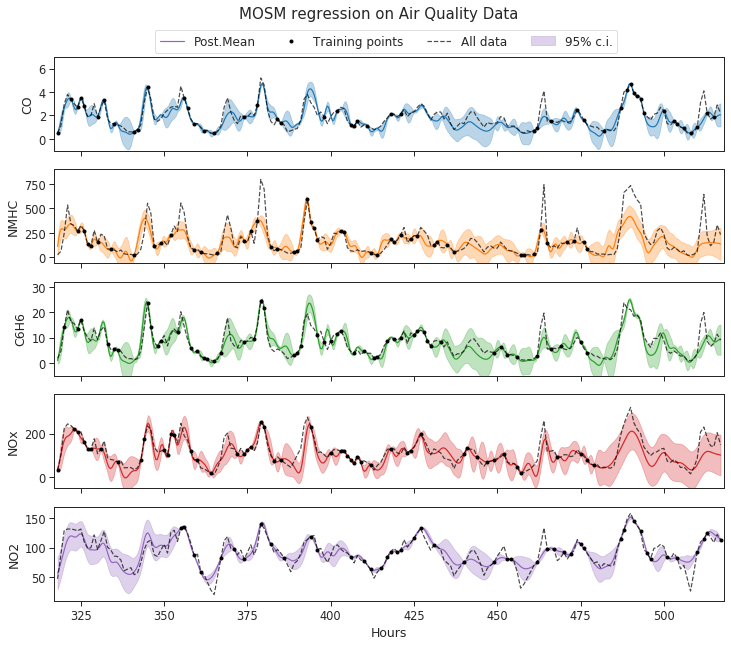

In [22]:
n_res = 500

for i in range(5):
    model_mosm.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_mosm.predict()

# plot
title = 'MOSM regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title
                   )
# plt.savefig('output/air_quality_mosm.pdf', bbox_inches='tight')

### Get error metrics per channel

* Mean absolute error per channel (MAE)
* Mean absolute percentual error per channel (MAPE)
* Mean squared error per channel (MSE)

In [23]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_mosm.predict(x_pred)

# obtain erros
mosm_mae = np.zeros(5)
mosm_mape = np.zeros(5)
mosm_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = df2[c] != -200
    mosm_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    mosm_mape[i] = np.abs((data.Y_all[i] - y_pred[i]) / data.Y_all[i] * 100).mean() # MAPE
    mosm_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[mosm_mae, mosm_mape, mosm_mse], columns=['MAE', 'MAPE', 'MSE'])

,MAE,MAPE,MSE
0,0.304050,17.260985,0.254586
1,59.522040,44.157733,11518.961266
2,1.680724,27.187472,7.073452
3,22.621419,21.585058,1210.042923
4,7.887351,11.239682,138.725557


# 3. Cross Spectral Mixture (CSM)

In [24]:
model_csm = mogptk.CSM(data, Q=4)
# model_csm.init_params()

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -200.075101
  Number of iterations: 16
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -16.965564
  Number of iterations: 79
  Number of functions evaluations: 88
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -183.759089
  Number of iterations: 200
  Number of functions evaluations: 297
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -64.136159
  Number of iterations: 222
  Number of functions evaluations: 285
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -102.885477
  Number of iterations: 57
  Number of functions evaluations: 7

In [25]:
model_csm.train(method='L-BFGS-B', maxiter=3000, learning_rate=0.001)

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1120.640642
  Number of iterations: 157
  Number of functions evaluations: 211
Done


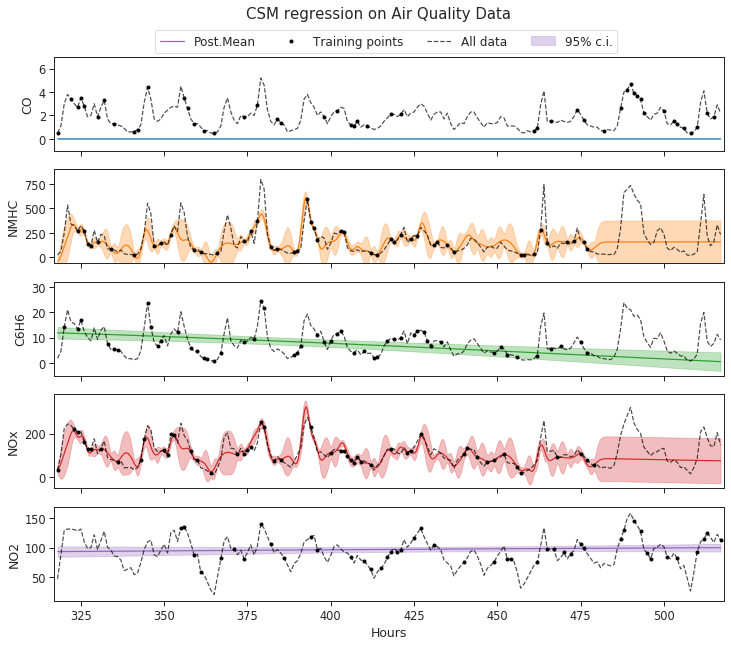

In [26]:
n_res = 500
for i in range(5):
    model_csm.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_csm.predict()

# plot
title = 'CSM regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title
                   )
# plt.savefig('output/air_quality_csm.pdf', bbox_inches='tight')

In [27]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_csm.predict(x_pred)

# obtain erros
csm_mae = np.zeros(5)
csm_mape = np.zeros(5)
csm_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = df2[c] != -200
    csm_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    csm_mape[i] = np.abs((data.Y_all[i] - y_pred[i]) / data.Y_all[i] * 100).mean() # MAPE
    csm_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[csm_mae, csm_mape, csm_mse], columns=['MAE', 'MAPE', 'MSE'])

,MAE,MAPE,MSE
0,1.882230,99.810451,4.512811
1,72.580323,63.800265,17388.513453
2,4.516215,95.372503,37.300037
3,29.542871,28.047534,2332.309847
4,19.701267,27.987179,636.830487


# 4. Spectral Mixture - Linear Model of Corregionalization (SM-LMC)

In [28]:
model_smlmc = mogptk.SM_LMC(data, Q=4)
model_smlmc.init_params()

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -211.888214
  Number of iterations: 17
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -15.668721
  Number of iterations: 72
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -180.981958
  Number of iterations: 91
  Number of functions evaluations: 124
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -44.381174
  Number of iterations: 100
  Number of functions evaluations: 120
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -105.135404
  Number of iterations: 68
  Number of functions evaluations: 99

In [29]:
model_smlmc.train(method='L-BFGS-B', maxiter=3000, learning_rate=0.001)

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 911.124349
  Number of iterations: 542
  Number of functions evaluations: 601
Done


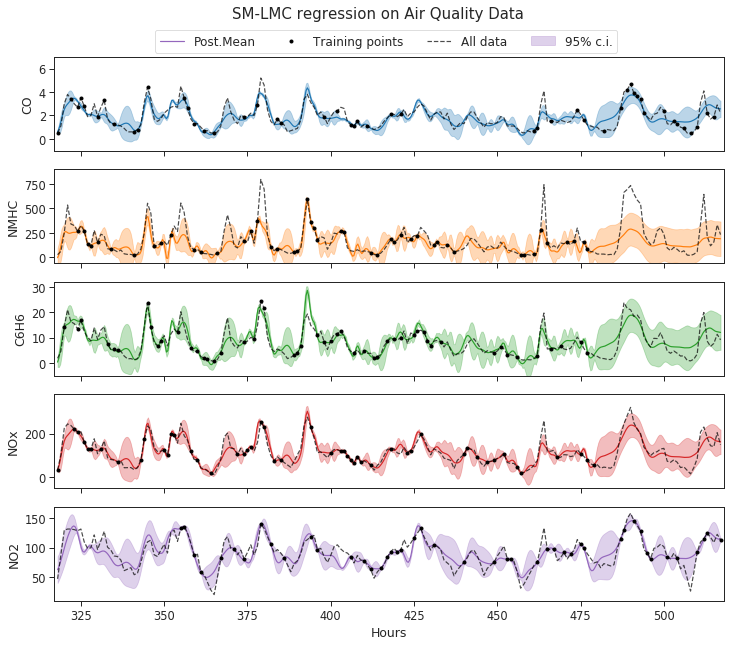

In [30]:
n_res = 500

for i in range(5):
    model_smlmc.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_smlmc.predict()

# pLot
title = 'SM-LMC regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title
                   )
# plt.savefig('output/air_quality_smlmc.pdf', bbox_inches='tight')

In [31]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_csm.predict(x_pred)

# obtain erros
smlmc_mae = np.zeros(5)
smlmc_mape = np.zeros(5)
smlmc_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = df2[c] != -200
    smlmc_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    smlmc_mape[i] = np.abs((data.Y_all[i] - y_pred[i]) / data.Y_all[i] * 100).mean() # MAPE
    smlmc_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[smlmc_mae, smlmc_mape, smlmc_mse], columns=['MAE', 'MAPE', 'MSE'])

,MAE,MAPE,MSE
0,1.882230,99.810451,4.512811
1,72.580323,63.800265,17388.513453
2,4.516215,95.372503,37.300037
3,29.542871,28.047534,2332.309847
4,19.701267,27.987179,636.830487


# 5. Convolutional Gaussian (CONV)

In [32]:
model_conv = mogptk.CG(data, Q=4)
model_conv.init_params()

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 63.533266
  Number of iterations: 37
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 307.820882
  Number of iterations: 30
  Number of functions evaluations: 34
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 159.835401
  Number of iterations: 38
  Number of functions evaluations: 68
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 267.038588
  Number of iterations: 230
  Number of functions evaluations: 318
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 210.392151
  Number of iterations: 72
  Number of functions evaluations: 94


In [33]:
model_conv.train(method='L-BFGS-B', maxiter=3000, learning_rate=0.001)

Building...
Optimizing...


InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[node GPR-f5098560-377/likelihood_1/Cholesky (defined at /home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/gpflow/models/gpr.py:72)  = Cholesky[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GPR-f5098560-377/likelihood_1/add_223)]]
	 [[{{node concat_1/_985}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17968_concat_1", tensor_type=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'GPR-f5098560-377/likelihood_1/Cholesky', defined at:
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 708, in __init__
    self.run()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-285bacaae318>", line 1, in <module>
    model_conv.train(method='L-BFGS-B', maxiter=3000, learning_rate=0.001)
  File "../mogptk/model.py", line 185, in train
    self.build(kind, disp)
  File "../mogptk/model.py", line 128, in build
    self.model = gpflow.models.GPR(x, y, self._kernel())
  File "</home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/decorator.py:decorator-gen-175>", line 2, in __init__
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/gpflow/core/compilable.py", line 156, in init_wrapper
    self.build()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/gpflow/models/model.py", line 80, in _build
    likelihood = self._build_likelihood()
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/gpflow/decors.py", line 49, in name_scope_wrapper
    return method(*args, **kwargs)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/gpflow/decors.py", line 67, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/gpflow/models/gpr.py", line 72, in _build_likelihood
    L = tf.cholesky(K)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 709, in cholesky
    "Cholesky", input=input, name=name)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[node GPR-f5098560-377/likelihood_1/Cholesky (defined at /home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/gpflow/models/gpr.py:72)  = Cholesky[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GPR-f5098560-377/likelihood_1/add_223)]]
	 [[{{node concat_1/_985}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17968_concat_1", tensor_type=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
n_res = 500

for i in range(5):
    model_conv.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_conv.predict()

# pLot
title = 'CONV regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title
                   )
# plt.savefig('output/air_quality_conv.pdf', bbox_inches='tight')

In [ ]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_csm.predict(x_pred)

# obtain erros
conv_mae = np.zeros(5)
conv_mape = np.zeros(5)
conv_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = df2[c] != -200
    conv_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    conv_mape[i] = np.abs((data.Y_all[i] - y_pred[i]) / data.Y_all[i] * 100).mean() # MAPE
    conv_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[conv_mae, conv_mape, conv_mse], columns=['MAE', 'MAPE', 'MSE'])